IMPORTING LIBRARIES

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

In [2]:
base_dir = "/home/meth/Desktop/beatrice/classes_equal"
train_path = "/home/meth/Desktop/beatrice/classes_equal/train data"
val_path = "/home/meth/Desktop/beatrice/classes_equal/validation data"
test_path = "/home/meth/Desktop/beatrice/classes_equal/test data"

LOADING DATA

In [3]:
batch_size = 16
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    train_path,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    val_path,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = image_dataset_from_directory(
    test_path,
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)



Found 294 files belonging to 3 classes.
Found 42 files belonging to 3 classes.
Found 84 files belonging to 3 classes.


W0000 00:00:1745491585.490937  182063 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 Load a pretrained ResNet50 model

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()
# Freeze the base model layers (to avoid updating them during training)
base_model.trainable = False

CNN MODEL

In [5]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: negative, TB, tb-hiv
])
 

In [6]:
fine_tune_at = 100  # Fine-tune layers from the 100th layer onward
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model after unfreezing layers (for fine-tuning)
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a low learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


TRAINING

In [ ]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100
)

Epoch 1/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.3573 - loss: 1.9304 - val_accuracy: 0.6429 - val_loss: 0.7746
Epoch 2/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.5154 - loss: 1.0785 - val_accuracy: 0.7857 - val_loss: 0.5686
Epoch 3/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.6697 - loss: 0.7552 - val_accuracy: 0.7857 - val_loss: 0.4753
Epoch 4/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.7127 - loss: 0.6258 - val_accuracy: 0.9286 - val_loss: 0.4234
Epoch 5/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 443ms/step - accuracy: 0.8073 - loss: 0.4924 - val_accuracy: 0.9286 - val_loss: 0.3955
Epoch 6/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.8053 - loss: 0.4738 - val_accuracy: 0.8333 - val_loss: 0.3610
Epoch 7/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 441ms/step - accuracy: 0.7579 - loss: 0.5359 - val_accuracy: 0.9524 - val_loss: 0.3360
Epoch 8/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 442ms/step - accuracy: 0.8043 - loss: 0.4542 - val_accuracy: 0

EVALUATION.

In [11]:

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
y_pred_probs = model.predict(test_ds)
 
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.7421 - loss: 0.5536
Test Accuracy: 0.7381
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step


2025-04-24 14:09:16.760930: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


CLASSIFICATION REPORT.

In [15]:
class_names = test_ds.class_names
 
# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

    negative       0.59      0.71      0.65        28
          tb       1.00      0.96      0.98        28
      tb-hiv       0.65      0.54      0.59        28

    accuracy                           0.74        84
   macro avg       0.75      0.74      0.74        84
weighted avg       0.75      0.74      0.74        84



VISUALIZATION.

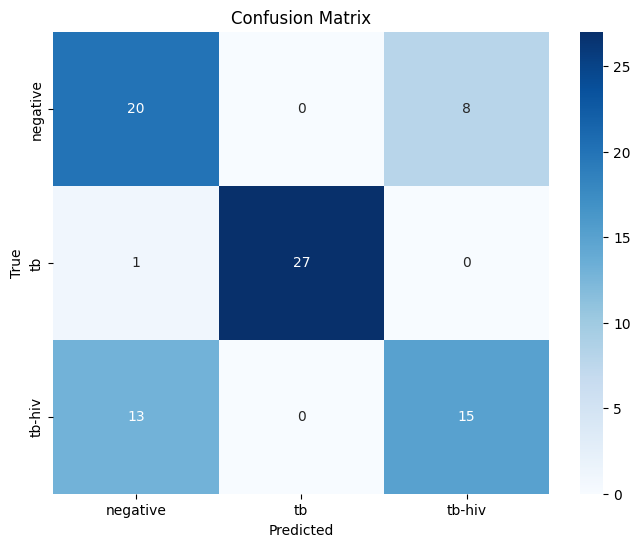

In [16]:
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

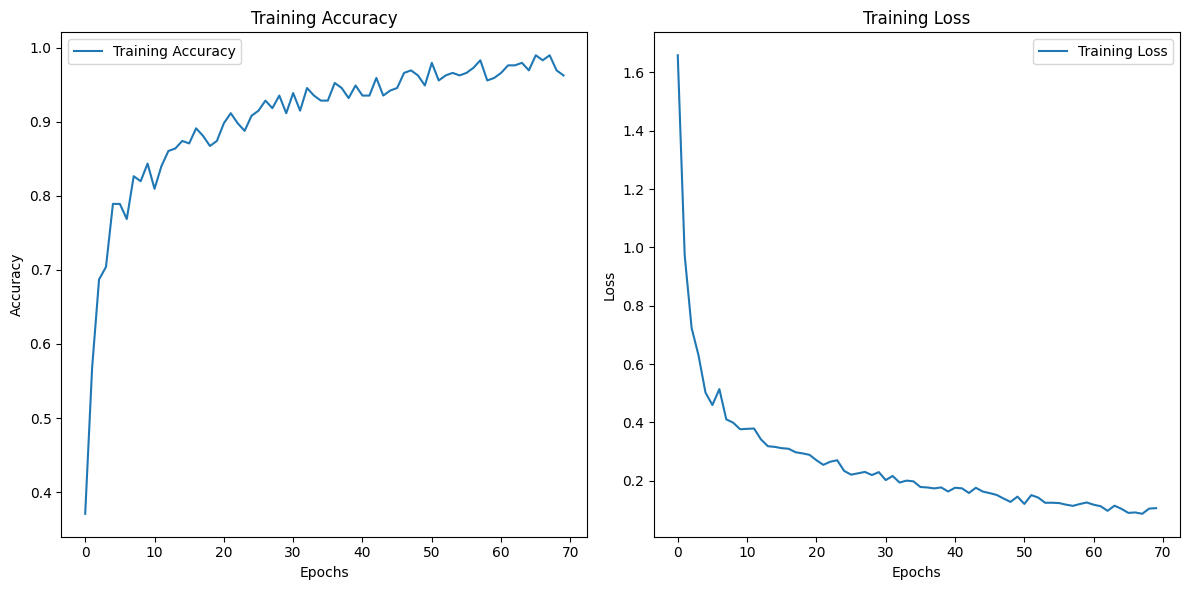

In [17]:

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

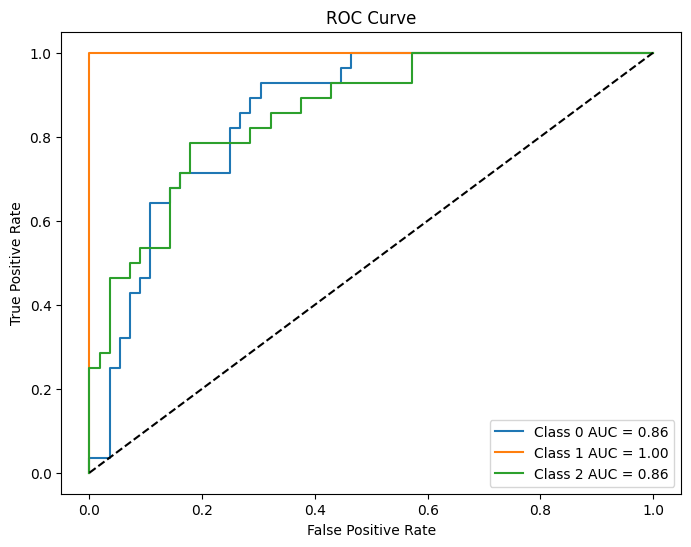

In [18]:
# ROC/AUC Analysis
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(tf.keras.utils.to_categorical(y_true, 3)[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} AUC = {roc_auc[i]:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

SAVING MODEL

In [20]:
model.save("disease_classifier_model.h5")